In [12]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from dataset import create_dataloaders
sys.path.append(os.path.abspath(".."))
data_root = os.path.abspath(os.path.join("..", "Aerial_Landscapes"))
from dataset import create_dataloaders

save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

Using device: mps

==================== Training with MINIMAL Augmentation ====================
Epoch 1/10 | Train Loss: 1.0383 | Train Acc: 0.7703 | Val Loss: 0.3276 | Val Acc: 0.9012
Epoch 2/10 | Train Loss: 0.1999 | Train Acc: 0.9440 | Val Loss: 0.2136 | Val Acc: 0.9287
Epoch 3/10 | Train Loss: 0.1143 | Train Acc: 0.9700 | Val Loss: 0.1912 | Val Acc: 0.9413
Epoch 4/10 | Train Loss: 0.0715 | Train Acc: 0.9783 | Val Loss: 0.1484 | Val Acc: 0.9542
Epoch 5/10 | Train Loss: 0.0590 | Train Acc: 0.9836 | Val Loss: 0.1658 | Val Acc: 0.9479
Epoch 6/10 | Train Loss: 0.0374 | Train Acc: 0.9907 | Val Loss: 0.1402 | Val Acc: 0.9604
Epoch 7/10 | Train Loss: 0.0353 | Train Acc: 0.9896 | Val Loss: 0.1440 | Val Acc: 0.9558
Epoch 8/10 | Train Loss: 0.0300 | Train Acc: 0.9917 | Val Loss: 0.1445 | Val Acc: 0.9579
Epoch 9/10 | Train Loss: 0.0230 | Train Acc: 0.9946 | Val Loss: 0.1477 | Val Acc: 0.9600
Epoch 10/10 | Train Loss: 0.0263 | Train Acc: 0.9931 | Val Loss: 0.1790 | Val Acc: 0.9529
绘制训练图表（minima

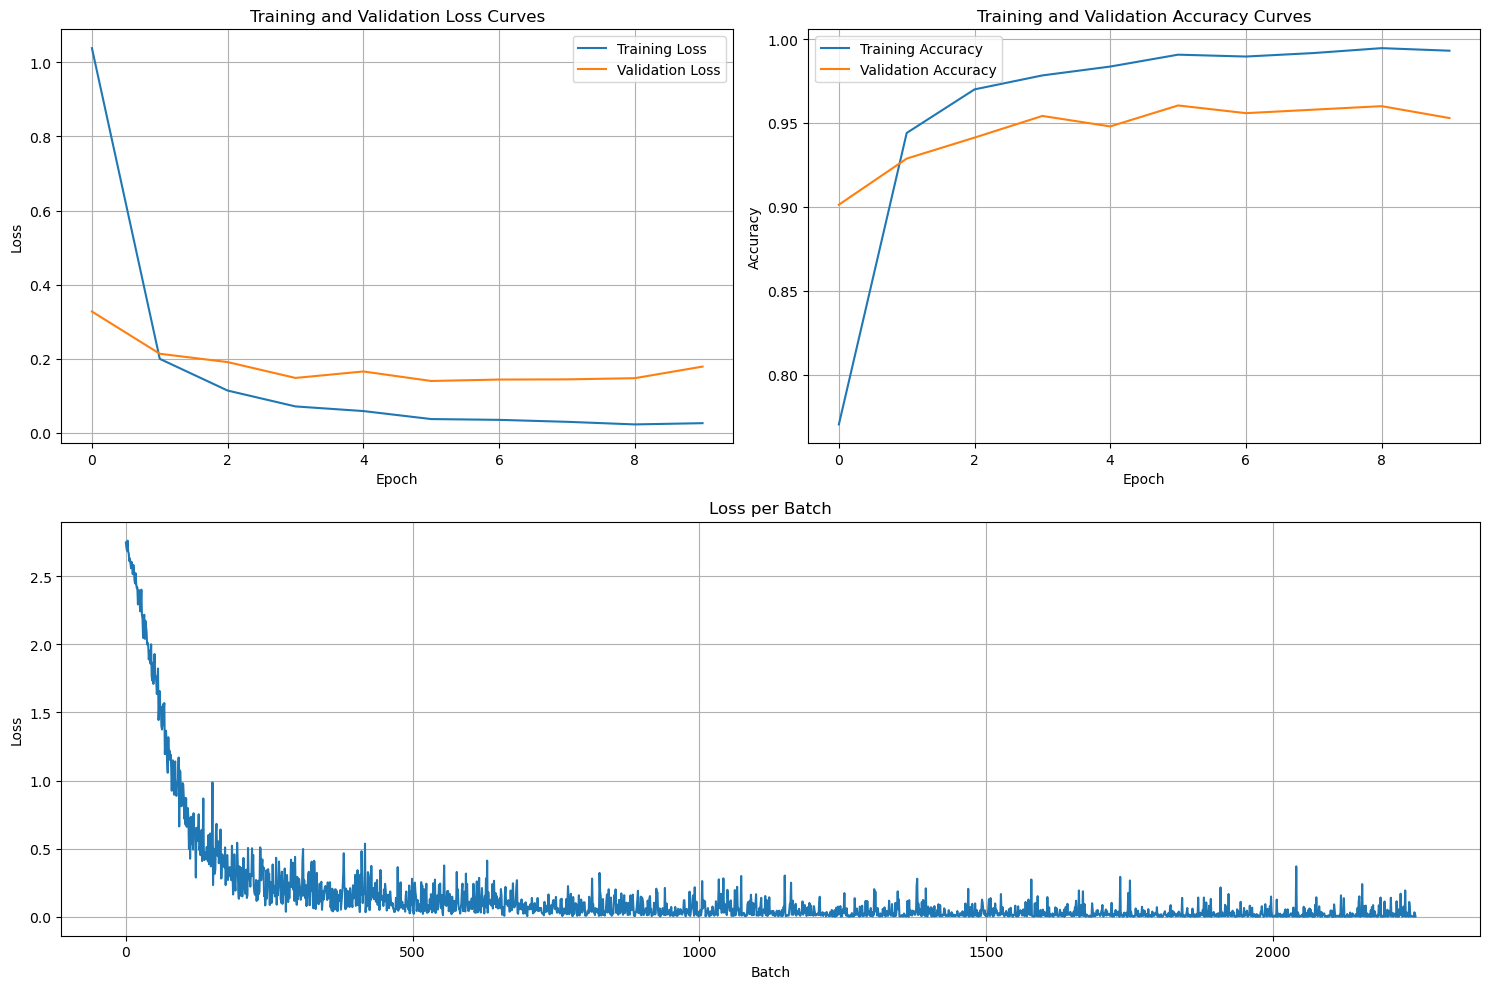

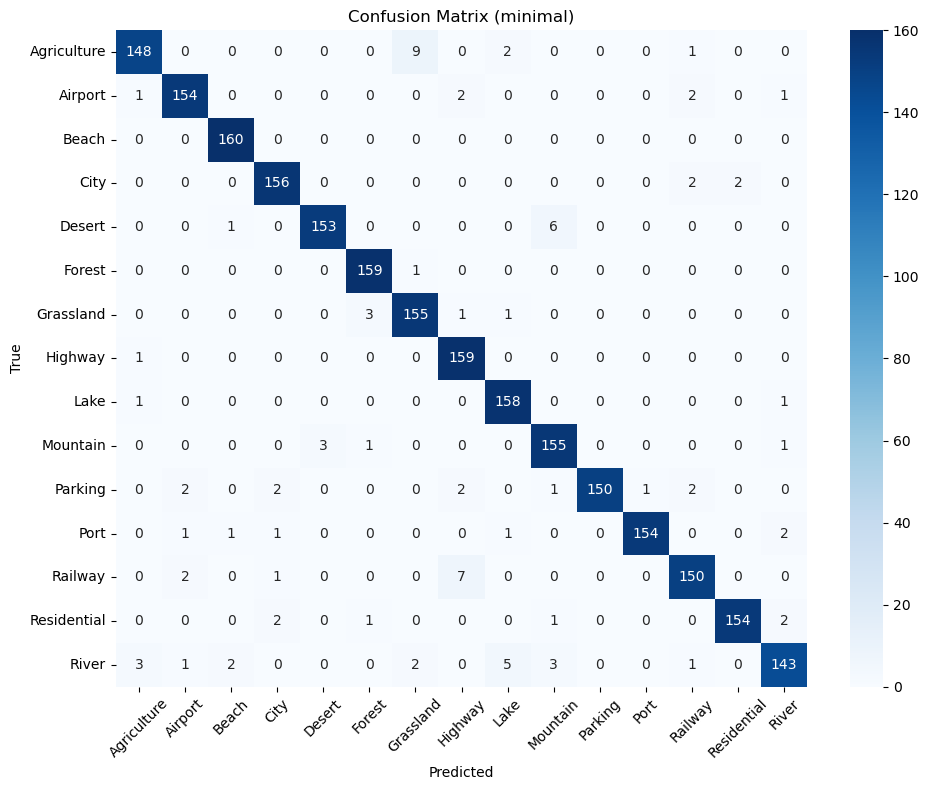


=== Precision / Recall / F1-score by Class (minimal) ===


,Class,Precision,Recall,F1-score
0,Agriculture,0.961,0.925,0.943
1,Airport,0.963,0.963,0.963
2,Beach,0.976,1.000,0.988
3,City,0.963,0.975,0.969
4,Desert,0.981,0.956,0.968
5,Forest,0.970,0.994,0.981
6,Grassland,0.928,0.969,0.948
7,Highway,0.930,0.994,0.961
8,Lake,0.946,0.988,0.966
9,Mountain,0.934,0.969,0.951



Macro Avg (minimal) → Precision: 0.962, Recall: 0.962, F1-score: 0.962

==================== Training with DEFAULT Augmentation ====================
Epoch 1/10 | Train Loss: 1.2131 | Train Acc: 0.6990 | Val Loss: 0.4097 | Val Acc: 0.8938
Epoch 2/10 | Train Loss: 0.3332 | Train Acc: 0.8989 | Val Loss: 0.2787 | Val Acc: 0.9121
Epoch 3/10 | Train Loss: 0.2430 | Train Acc: 0.9236 | Val Loss: 0.2374 | Val Acc: 0.9229
Epoch 4/10 | Train Loss: 0.2025 | Train Acc: 0.9368 | Val Loss: 0.2209 | Val Acc: 0.9308
Epoch 5/10 | Train Loss: 0.1508 | Train Acc: 0.9531 | Val Loss: 0.1955 | Val Acc: 0.9354
Epoch 6/10 | Train Loss: 0.1327 | Train Acc: 0.9592 | Val Loss: 0.1738 | Val Acc: 0.9433
Epoch 7/10 | Train Loss: 0.1203 | Train Acc: 0.9626 | Val Loss: 0.1787 | Val Acc: 0.9458
Epoch 8/10 | Train Loss: 0.1046 | Train Acc: 0.9667 | Val Loss: 0.1834 | Val Acc: 0.9471
Epoch 9/10 | Train Loss: 0.0929 | Train Acc: 0.9700 | Val Loss: 0.1885 | Val Acc: 0.9429
Epoch 10/10 | Train Loss: 0.0895 | Train Acc: 0.9

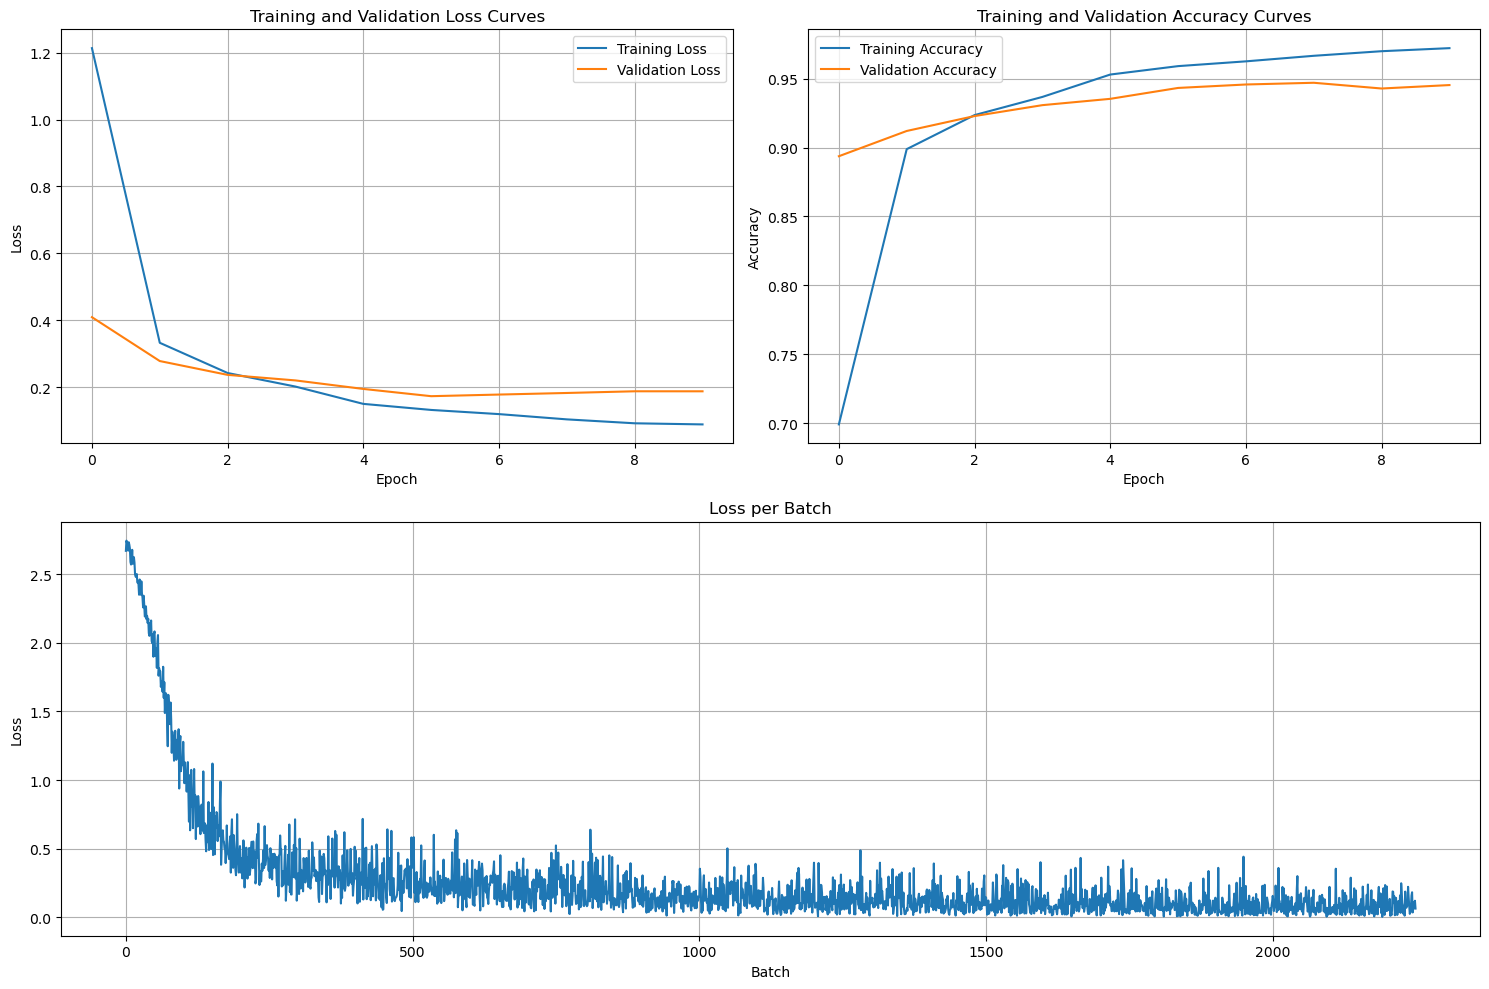

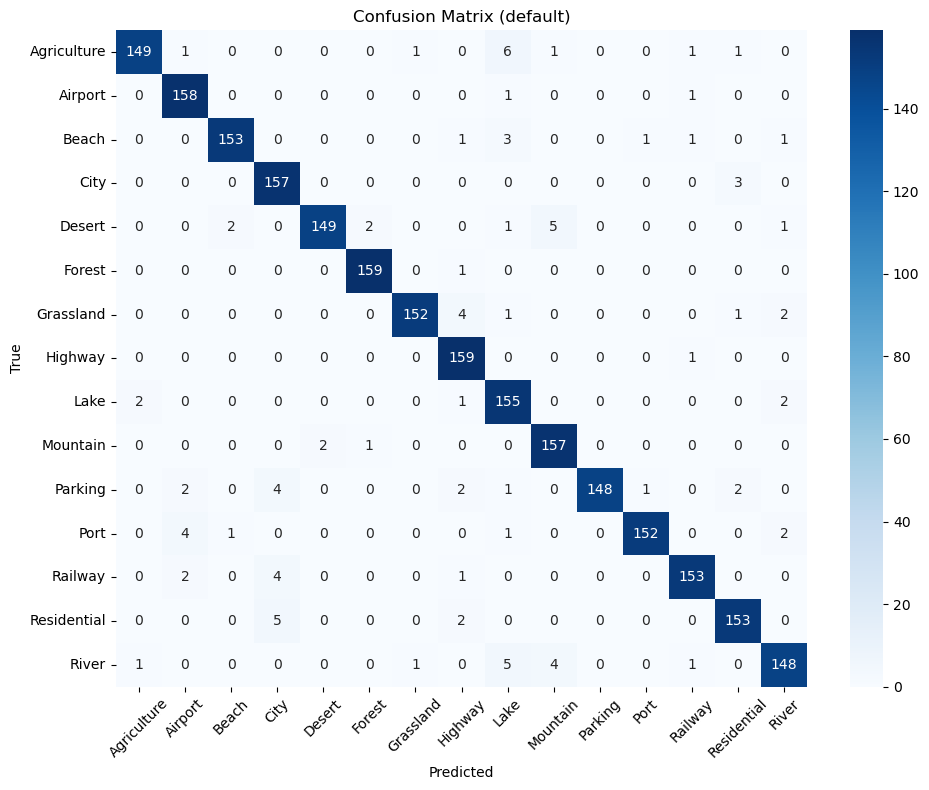


=== Precision / Recall / F1-score by Class (default) ===


,Class,Precision,Recall,F1-score
0,Agriculture,0.980,0.931,0.955
1,Airport,0.946,0.988,0.966
2,Beach,0.981,0.956,0.968
3,City,0.924,0.981,0.952
4,Desert,0.987,0.931,0.958
5,Forest,0.981,0.994,0.988
6,Grassland,0.987,0.950,0.968
7,Highway,0.930,0.994,0.961
8,Lake,0.891,0.969,0.928
9,Mountain,0.940,0.981,0.960



Macro Avg (default) → Precision: 0.960, Recall: 0.959, F1-score: 0.959

==================== Training with EXTENSIVE Augmentation ====================
Epoch 1/10 | Train Loss: 1.3590 | Train Acc: 0.6483 | Val Loss: 0.5894 | Val Acc: 0.8337
Epoch 2/10 | Train Loss: 0.4704 | Train Acc: 0.8567 | Val Loss: 0.3891 | Val Acc: 0.8888
Epoch 3/10 | Train Loss: 0.3394 | Train Acc: 0.8939 | Val Loss: 0.3315 | Val Acc: 0.9033
Epoch 4/10 | Train Loss: 0.2889 | Train Acc: 0.9085 | Val Loss: 0.3106 | Val Acc: 0.9029
Epoch 5/10 | Train Loss: 0.2526 | Train Acc: 0.9183 | Val Loss: 0.3248 | Val Acc: 0.9038
Epoch 6/10 | Train Loss: 0.2339 | Train Acc: 0.9275 | Val Loss: 0.2721 | Val Acc: 0.9154
Epoch 7/10 | Train Loss: 0.2214 | Train Acc: 0.9290 | Val Loss: 0.2397 | Val Acc: 0.9242
Epoch 8/10 | Train Loss: 0.1983 | Train Acc: 0.9372 | Val Loss: 0.2290 | Val Acc: 0.9329
Epoch 9/10 | Train Loss: 0.1782 | Train Acc: 0.9429 | Val Loss: 0.2250 | Val Acc: 0.9337
Epoch 10/10 | Train Loss: 0.1607 | Train Acc: 0

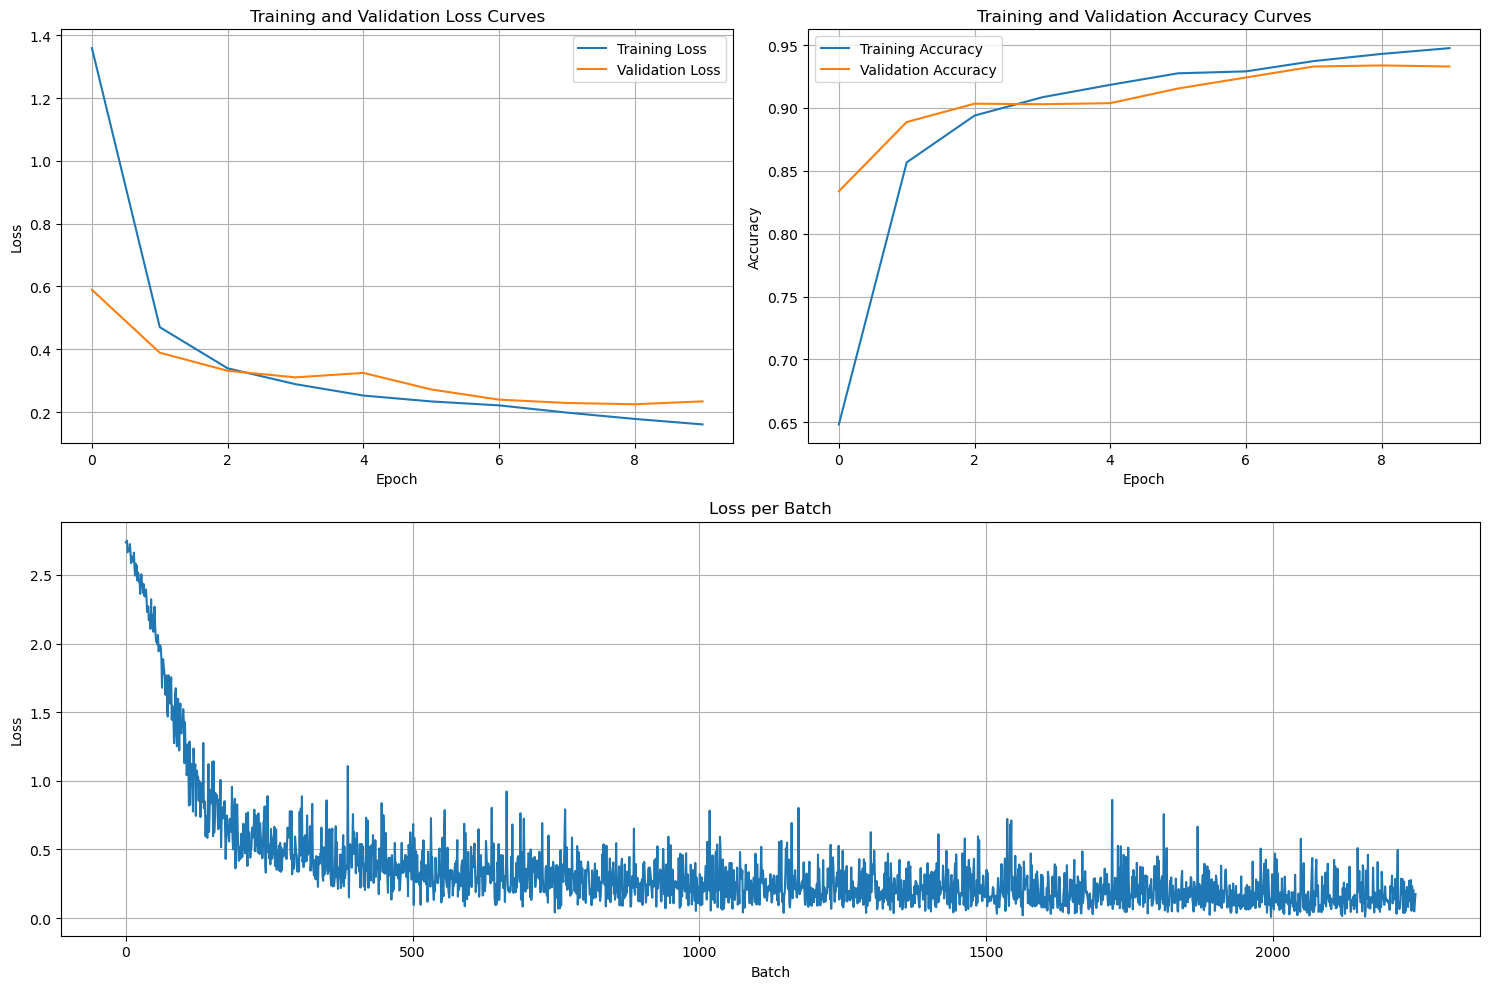

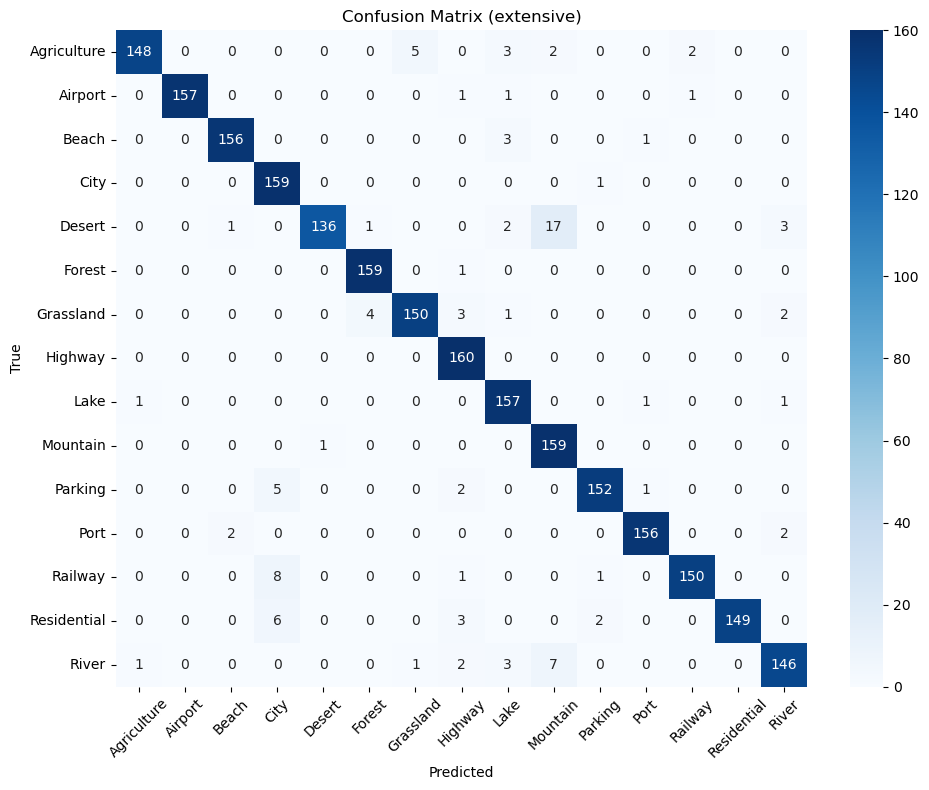


=== Precision / Recall / F1-score by Class (extensive) ===


,Class,Precision,Recall,F1-score
0,Agriculture,0.987,0.925,0.955
1,Airport,1.000,0.981,0.991
2,Beach,0.981,0.975,0.978
3,City,0.893,0.994,0.941
4,Desert,0.993,0.850,0.916
5,Forest,0.970,0.994,0.981
6,Grassland,0.962,0.938,0.949
7,Highway,0.925,1.000,0.961
8,Lake,0.924,0.981,0.952
9,Mountain,0.859,0.994,0.922



Macro Avg (extensive) → Precision: 0.958, Recall: 0.956, F1-score: 0.956


In [13]:
# 3. 设置设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 4. 训练函数（含 batch loss）
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    batch_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            batch_losses.append(loss.item())

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss_list.append(running_train_loss / len(train_loader))
        train_acc_list.append(correct_train / total_train)

        # 验证
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss_list.append(running_val_loss / len(val_loader))
        val_acc_list.append(correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_list[-1]:.4f} | Train Acc: {train_acc_list[-1]:.4f} | Val Loss: {val_loss_list[-1]:.4f} | Val Acc: {val_acc_list[-1]:.4f}")

    return {
        'train_loss': train_loss_list,
        'train_acc': train_acc_list,
        'val_loss': val_loss_list,
        'val_acc': val_acc_list,
        'batch_losses': batch_losses
    }

# 5. 绘制训练曲线图表
def plot_training_history(history, strategy_name):
    print(f"绘制训练图表（{strategy_name}）...")
    plt.figure(figsize=(15, 10))

    # 损失曲线
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)

    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)

    # 每个 batch 的损失
    plt.subplot(2, 1, 2)
    plt.plot(range(len(history['batch_losses'])), history['batch_losses'])
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss per Batch')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'training_history_{strategy_name}.png')
    plt.show()

# 6. 评估函数
def evaluate(model, test_loader, classes, strategy_name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(f"Confusion Matrix ({strategy_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # PRF 表格
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    report_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })
    print(f"\n=== Precision / Recall / F1-score by Class ({strategy_name}) ===")
    display(report_df.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-score": "{:.3f}"}))

    # 宏平均
    p_macro, r_macro, f1_macro = precision_recall_fscore_support(all_labels, all_preds, average='macro')[:3]
    print(f"\nMacro Avg ({strategy_name}) → Precision: {p_macro:.3f}, Recall: {r_macro:.3f}, F1-score: {f1_macro:.3f}")

# 7. 主程序：三种策略对比
augmentation_strategies = ['minimal', 'default', 'extensive']

for strategy in augmentation_strategies:
    print(f"\n==================== Training with {strategy.upper()} Augmentation ====================")

    # 数据加载
    train_loader, val_loader, test_loader, classes = create_dataloaders(
        root_dir=data_root,
        batch_size=32,
        augmentation_strategy=strategy,
        split_ratio=[0.6, 0.2, 0.2],
        num_workers=0,
        verbose=False
    )

    # 模型初始化
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
    model = model.to(device)

    # 优化器 & 损失函数
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # 训练
    history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

    # 绘图 + 评估
    plot_training_history(history, strategy)
    evaluate(model, test_loader, classes, strategy)
    model_path = os.path.join(save_dir, f"efficientnet_{strategy}.pt")
    torch.save(model.state_dict(), model_path)
